In [ ]:
# === EXECUTE THIS CELL ===

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import time
from numpy.fft import fft2, ifft2
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter

# Shrinkage of circular grain

In [21]:
# === EXECUTE THIS CELL, TOO ===

def allen_cahn_circular(M, kappa, A, B):
    # === Simulation Parameters ===
    N = 64
    dx = dy = 0.5
    dt = 0.005
    nsteps = 5000

    # === Wavenumber grid ===
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    # === Free energy derivative ===
    def dfdeta(etas, eta_i):
        sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
        return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

    # === Circular Two-Grain Initialization ===
    def init_circular_two_grains(Nx, Ny):
        ngrain = 2
        etas = np.zeros((ngrain, Nx, Ny))
        glist = np.ones(ngrain, dtype=bool)

        x0, y0 = Nx / 2, Ny / 2
        radius = 14.0

        for i in range(Nx):
            for j in range(Ny):
                dist = np.sqrt((i - x0) ** 2 + (j - y0) ** 2)
                if dist <= radius:
                    etas[1, i, j] = 1.0  # Circular grain
                else:
                    etas[0, i, j] = 1.0  # Matrix
        return etas, ngrain, glist

    # === Initialize microstructure ===
    etas, ngrains, glist = init_circular_two_grains(N, N)

    # === Pandas DataFrame to store area fraction evolution ===
    area_records = []

    # === Precompute snapshot steps
    snapshot_steps = [1, int(0.2 * nsteps), int(0.4 * nsteps), int(0.6 * nsteps), int(0.8 * nsteps), nsteps]

    # === Time-stepping loop ===
    start_time = time.time()
    for step in range(1, nsteps + 1):
        for ig in range(ngrains):
            if not glist[ig]:
                continue
            eta = etas[ig]
            dfdeta_real = dfdeta(etas, eta)
            dfdeta_hat = fft2(dfdeta_real)

            # Semi-implicit spectral update
            eta_hat = fft2(eta)
            eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
            eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
            etas[ig] = eta

        # Compute area fraction of the shrinking grain (grain index 1)
        mask = etas[1] >= 0.5
        area_fraction = np.sum(mask) / (N * N)
        area_records.append({'time': step * dt, 'area_fraction': area_fraction})

        # Plot snapshots at key steps
        if step in snapshot_steps:
            eta2 = np.sum(etas**2, axis=0)
            plt.figure(figsize=(2, 2))
            plt.imshow(eta2, cmap='viridis')
            plt.title(f'Step {step}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    total_time = time.time() - start_time
    print(f"Total compute time: {total_time:.2f} seconds")

    # === Convert to DataFrame ===
    area_df = pd.DataFrame(area_records)

    # === Plot the grain area evolution ===
    sns.lineplot(data=area_df, x='time', y='area_fraction')
    plt.gca().set_ylim(bottom=0)
    plt.xlabel('Time')
    plt.ylabel('Grain Area Fraction')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

    return

# Exercise: Allen-Cahn and Grain Growth
The program solves the non-conserved multi-component Allen–Cahn equation.
The free energy density is coded as:
$$
f(\eta_1,\eta_2, \ldots, \eta_N) = \sum_{i=1}^N \left( - \frac{A}{2} \eta_i^2 + \frac{B}{4} \eta_i^4 + \sum_{i=1}^N \sum_{j\neq i}^N \eta_i^2\eta_j^2 \right).
$$

#### Task a

Plot the local free energy functional (z-axis) for $A = B = 1$ as a function of two order parameters, $\eta_1$ (x-axis) and $\eta_2$ (y-axis). Include the plot in your presentation and discuss the physical meaning of this free energy density in the context of grain growth.

#### Task b

Run the following program using a mobility of $4.0$ and a gradient coefficient of $0.1$.

The simulation produces snapshots showing the time evolution of the microstructure and a final plot of the area fraction of the embedded grain over time. Why is the area proportional to $t^2$?

In [25]:
# === System-specific Parameters ===
M = 4.0             # Mobility
kappa = 0.1         # Gradient coefficient
A, B = 1.0, 1.0     # Free energy parameters

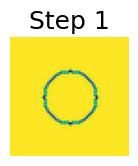

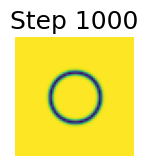

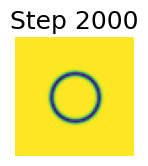

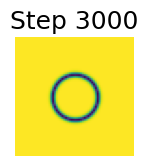

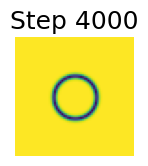

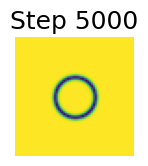

Total compute time: 2.73 seconds


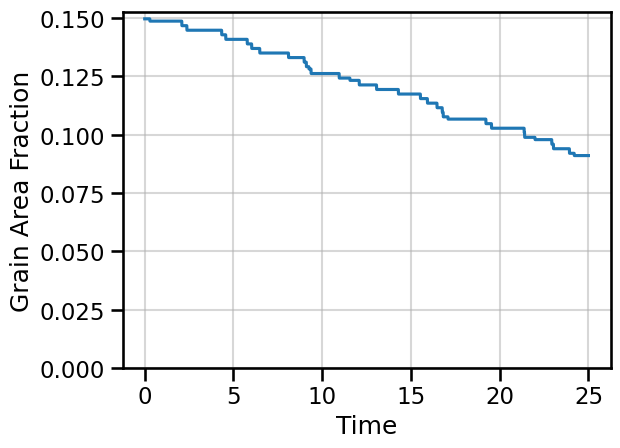

In [26]:
allen_cahn_circular(M, kappa, A, B)

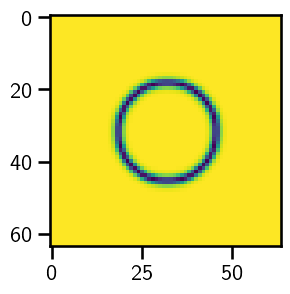

In [ ]:
# === Optional: Create GIF Animation ===
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(snapshots[0][1], cmap='viridis')
#tx = ax.text(N * 0.7, N * 0.05, f't={snapshots[0][0]:.3f}', bbox=dict(boxstyle="round", ec='white', fc='white'))

def animate(i):
    t, eta_frame = snapshots[i]
    im.set_data(eta_frame)
    tx.set_text(f't={t:.3f}')
    return im, tx

ani = animation.FuncAnimation(fig, animate, frames=len(snapshots),
                              interval=50, blit=False)

ani.save('circular_two_grain.gif', writer='pillow', fps=5, dpi=150)

# Display the GIF
display(Image(filename="circular_two_grain.gif"))

#### Task c

Run the program using: 
- a mobility of $2.0$ and a gradient coefficient of $0.1$,
- a mobility of $2.0$ and a gradient coefficient of $0.2$,

and compare the results with the previous task.
Why does the gradient term affect the result ? 

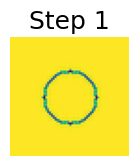

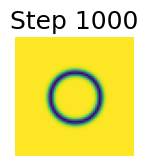

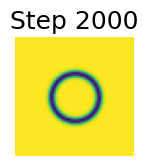

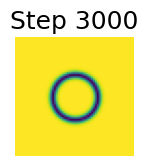

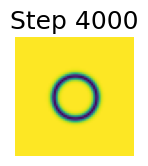

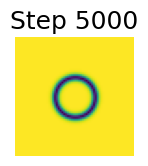

Total compute time: 3.09 seconds


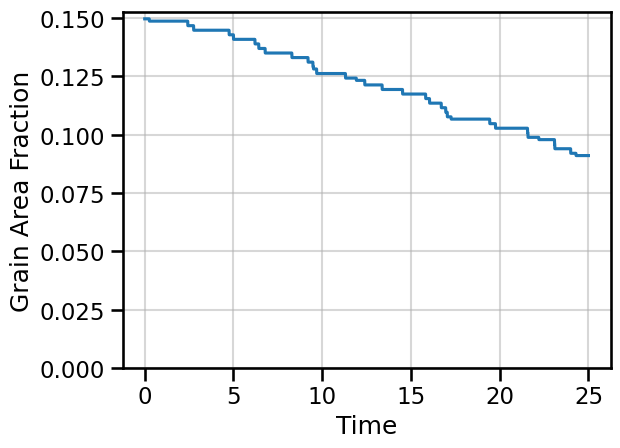

In [29]:
allen_cahn_circular(2.0, 0.2, A, B)

# Ostwald ripening of Voronoi microstructure

In [17]:
# === System-specific Parameters ===
M = 5.0                    # Mobility
kappa = 0.2                # Gradient coefficient
A, B = 1.0, 1.0            # Free energy parameters

ngrains = 25               # Number of grains
rng_seed = 1234            # RNG seed for reproducibility

In [18]:
def allen_cahn_voronoi(M, kappa, A, B, ngrains, rng_seed):
    # === Fixed Simulation Parameters ===
    N = 64                     # Grid size
    dx = dy = 0.5              # Grid spacing
    nsteps = 20000             # Number of time steps
    dt = 0.005                 # Time step size
    smoothing_sigma = 1.5      # Gaussian smoothing for initial microstructure
    snapshot_interval = 100    # Snapshot frequency

    # === Wavenumber grid ===
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    def dfdeta(etas, eta_i):
        sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
        return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

    def procedural_voronoi_smoothed(Nx, Ny, ngrains, sigma):
        np.random.seed(rng_seed)
        points = np.random.rand(ngrains, 2) * [Nx, Ny]
        tree = cKDTree(points)
        x = np.arange(Nx) + 0.5
        y = np.arange(Ny) + 0.5
        X, Y = np.meshgrid(x, y, indexing='ij')
        grid_points = np.stack((X.ravel(), Y.ravel()), axis=-1)
        _, grain_ids = tree.query(grid_points)
        grain_map = grain_ids.reshape(Nx, Ny)

        etas = np.zeros((ngrains, Nx, Ny))
        for i in range(ngrains):
            etas[i] = (grain_map == i).astype(float)

        etas_smoothed = gaussian_filter(etas, sigma=(0, sigma, sigma))
        etas_smoothed /= np.sum(etas_smoothed, axis=0, keepdims=True)
        return etas_smoothed, ngrains, np.ones(ngrains, dtype=bool), grain_map

    etas, ngrains, glist, grain_map = procedural_voronoi_smoothed(N, N, ngrains, smoothing_sigma)


    area_fraction_records = []

    def show_microstructure(etas, step, event=""):
        eta2 = np.sum(etas**2, axis=0)
        plt.figure(figsize=(2.5, 2.5))
        plt.imshow(eta2, cmap='viridis', vmin=0.0, vmax=1.0)
        plt.title(f'{event}\nStep {step}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    start_time = time.time()
    show_microstructure(etas, step=0, event="Initial")

    for step in range(1, nsteps + 1):
        for ig in range(ngrains):
            if not glist[ig]:
                continue
            eta = etas[ig]
            dfdeta_real = dfdeta(etas, eta)
            dfdeta_hat = fft2(dfdeta_real)
            eta_hat = fft2(eta)
            eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
            eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
            etas[ig] = eta

            if np.sum(eta) / (N * N) <= 0.001:
                glist[ig] = False
                etas[ig] = 0.0
                show_microstructure(etas, step=step, event=f"Grain {ig+1} eliminated")

        # Store area fractions
        if step % snapshot_interval == 0 or step == 1:
            fractions = [np.sum(etas[ig]) / (N * N) if glist[ig] else 0.0 for ig in range(ngrains)]
            record = {'time': step * dt}
            for ig in range(ngrains):
                record[f'grain_{ig+1}'] = fractions[ig]
            area_fraction_records.append(record)

    total_time = time.time() - start_time
    print(f"\nTotal compute time: {total_time:.2f} seconds")

    area_df = pd.DataFrame(area_fraction_records)

    # === Plot area fraction evolution ===
    color_cycle = plt.cm.tab10.colors
    linestyles = ['-', '--', '-.', ':']
    style_cycler = itertools.cycle([(color, ls) for ls in linestyles for color in color_cycle])

    plt.figure(figsize=(12, 4))
    for col in area_df.columns:
        if col == 'time':
            continue
        color, ls = next(style_cycler)
        sns.lineplot(x=area_df['time'], y=area_df[col], label=col, color=color, linestyle=ls, linewidth=1)

    plt.xlabel('Time')
    plt.ylabel('Area Fraction')
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=2, fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

    return

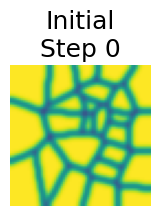

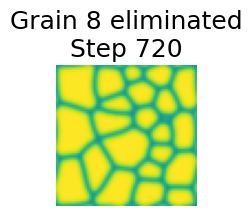

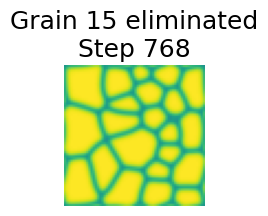

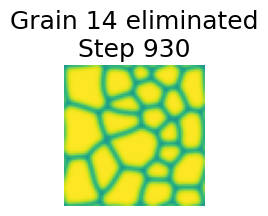

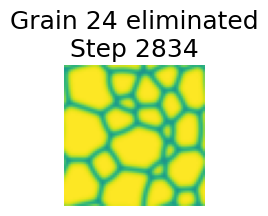

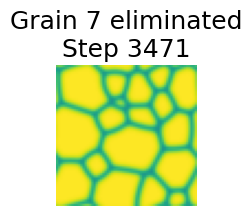

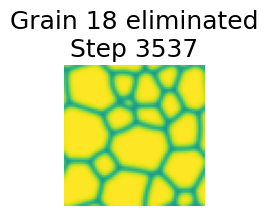

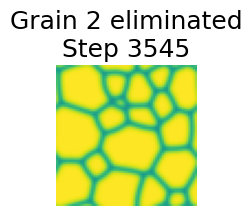

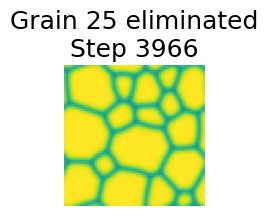

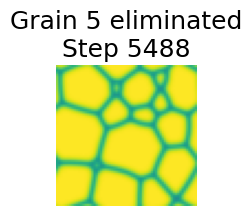

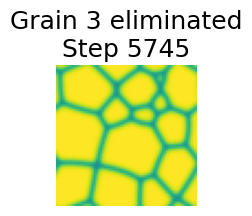

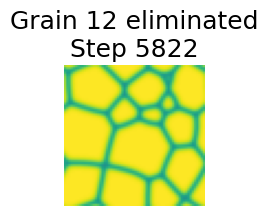

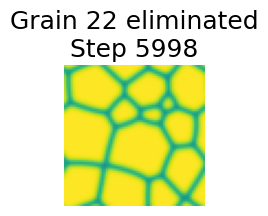

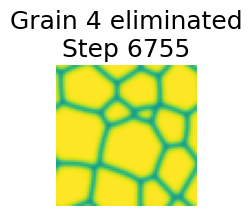

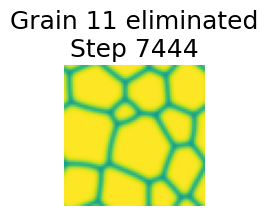

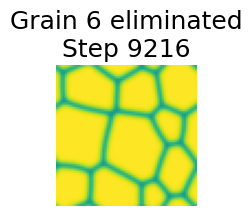

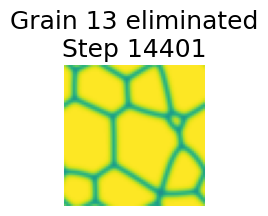

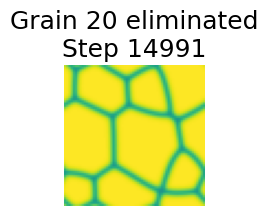


Total compute time: 82.41 seconds


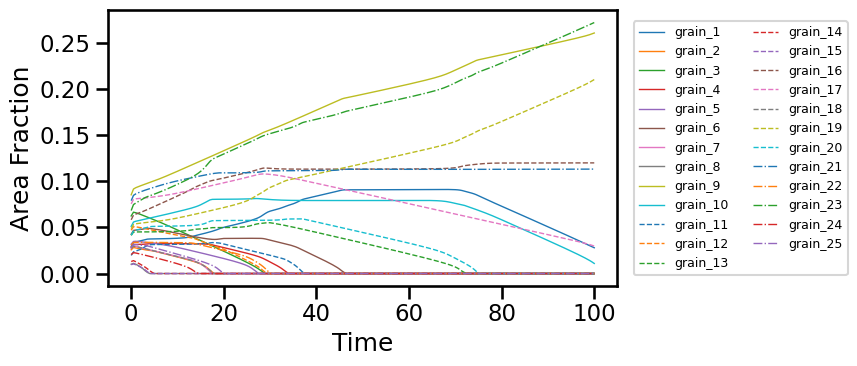

In [20]:
allen_cahn_voronoi(M, kappa, A, B, ngrains, rng_seed)

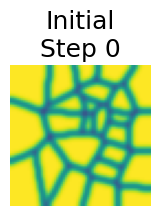

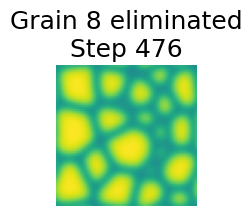

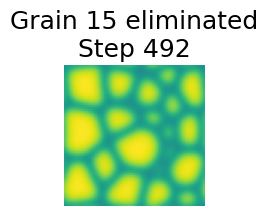

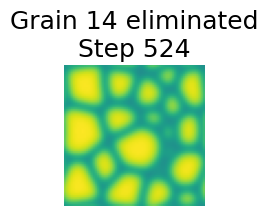

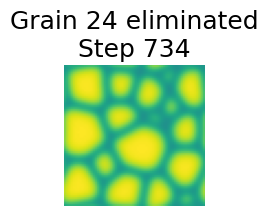

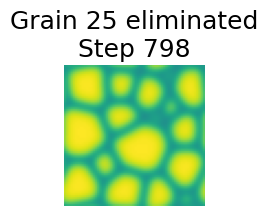

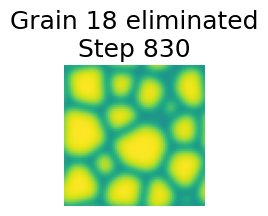

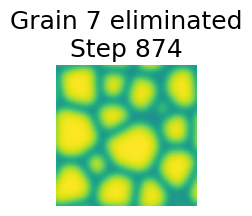

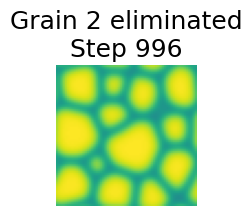

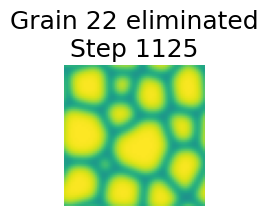

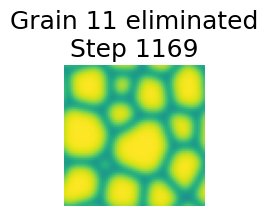

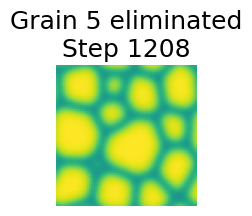

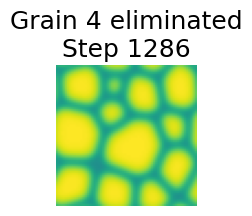

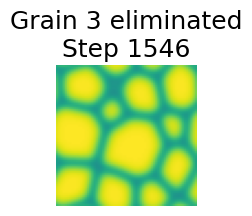

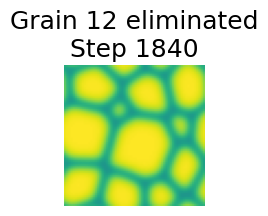

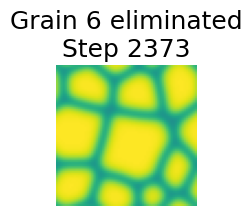

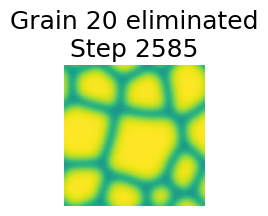

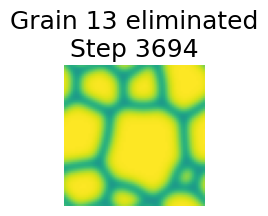

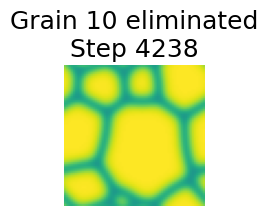

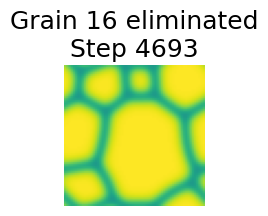

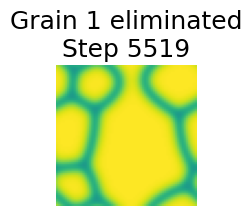

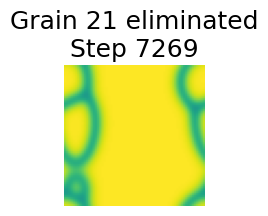

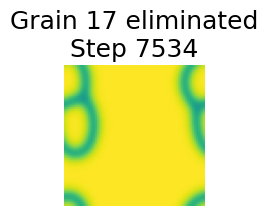

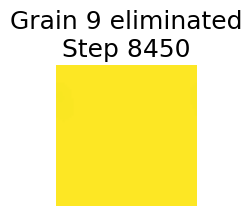

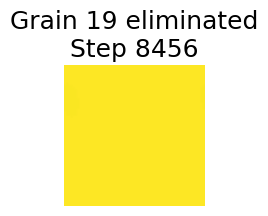


Total compute time: 32.47 seconds


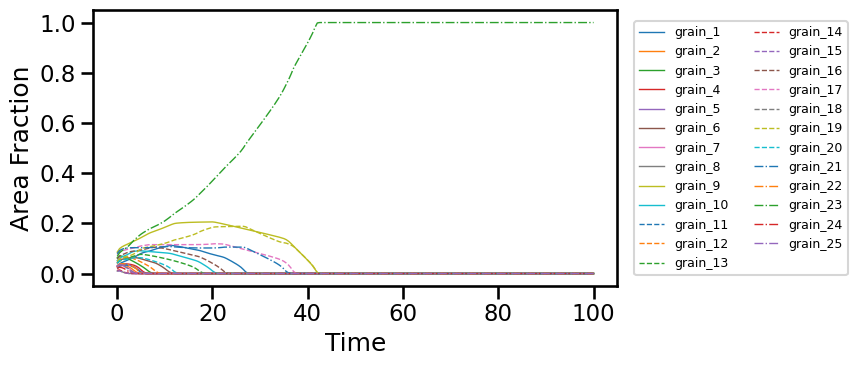

In [31]:
allen_cahn_voronoi(5.0, 0.8, A, B, ngrains, rng_seed)

In [ ]:
# === Optional: Create GIF Animation ===
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(snapshots[0][1], cmap='bwr', vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r'$\sum \eta_i^2$', shrink=0.8)
tx = ax.text(N * 0.7, N * 0.05, f't={snapshots[0][0]:.3f}',
             bbox=dict(boxstyle="round", ec='white', fc='white'))


def animate(i):
    t, eta_frame = snapshots[i]
    im.set_data(eta_frame)
    tx.set_text(f't={t:.3f}')
    return im, tx

ani = animation.FuncAnimation(fig, animate, frames=len(snapshots),
                              interval=50, blit=False)

ani.save('voronoi.gif', writer='pillow',fps=20,dpi=150)

# Display the GIF
display(Image(filename="voronoi.gif"))